# ALeRCE classifiers: stamp classifier and light curve classifier

```Authors: Rodrigo Carrasco-Davis, Ignacio Reyes. Last updated: 20200922```

For more information about the ALeRCE broker, please visit http://alerce.science/, or take a look to our presentation paper: Förster et al. 2020 (https://arxiv.org/abs/2008.03311).

Note that this notebook uses the experimental ALeRCE API, which can be cloned and installed (`pip install -e .`) from https://github.com/alercebroker/alerce_client_new. The documentation is currently under development in: https://alerce-new-python-client.readthedocs.io/en/latest/index.html

# Table of contents:
* [Requirements](#req)
* [Frontend](#frontend)
* [Stamp classifier](#stamp)
    * [Description](#stamp-description)
    * [Getting stamps with python client](#stamp-retrieval)
    * [Check light curve lengths for predicted objects](#stamp-lengths)
    * [Spatial distribution of predictions](#stamp-spatial)
* [Light curve classifier](#lc)
    * [Description](#lc-description)
    * [Querying the DB to retrieve predictions](#db-query)
    * [Histogram of predicted classes](#lc-histogram)
    * [Spatial distribution of predictions](#lc-spatial)
    * [Visualization of some light curves per class](#lc-visualization)


# Requirements <a class="anchor" id="req"></a>

## Installing ALeRCE client (dev version)

Install and import the new alerce API client https://github.com/alercebroker/alerce_client_new

Clone and `pip install -e .`

In [ ]:
!git clone https://github.com/alercebroker/alerce_client_new.git
!pip install -e alerce_client_new/

In [1]:
from IPython.display import display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from astropy.time import Time
import astropy.units as units
from astropy.coordinates import SkyCoord
import ephem

from tqdm import tqdm
import copy
import pickle
import psycopg2
import json
import requests

In [2]:
from alerce.core import Alerce
alerce_client = Alerce()

# Frontend: ALeRCE Explorer and Supernova Hunter <a class="anchor" id="frontend"></a>

## ALeRCE Explorer

All the data in ALeRCE's database, including model predictions, can be seen using the ALeRCE Explorer. The explorer is available in https://alerce.online

This webpage is currently being updated, so the shown predictions can be out of date.

![ALeRCE_Explorer](figures/ml/alerce_explorer.png)

Once an object is selected, all available information about it is shown. The figure in the bottom center shows the probabilities given by the light curve classifier.

![alerce_explorer_object](figures/ml/alerce_explorer_object.png)


## Supernova Hunter

The [Supernova Hunter](https://snhunter.alerce.online/) is a visualization tool that allows the user to inspect SN candidates classified by the model in real time, in order to select good targets for follow-up observations.

<img src="figures/ml/sn_hunter.png" width=90% />

On the bottom left side, the location of each candidate in sky coordinates with respect to the Galactic plane and the ecliptic are depicted. On the bottom right side, a selection of the top candidates is listed, initially ordered by SN probability score from the stamp classifier. The list of candidates can be sorted by other parameters, and updated/refreshed to include newly ingested alerts. On the top left side, the SN candidate ID is shown as a clickable link to the [ALeRCE frontend](https://alerce.online/object/ZTF20abpvolc), with relevant metadata such as radec coordinates, magnitude, date, etc. At the bottom there are links to other sources of information, including ALeRCE, NED, TNS, and the Simbad Astronomical Database. In the middle of the figure there is a colored image from Aladin. On the top right side, the stamps of the first detection are shown, along with buttons for reporting the candidate as eventual bogus or as a possible SN.

# Stamp classifier <a class="anchor" id="stamp"></a>

## Description<a class="anchor" id="stamp-description"></a>

In this section we will explore the results of the ALeRCE Stamp Classifier, explained in **Carrasco-Davis et al 2020 (https://arxiv.org/abs/2008.03309)**, which is based on a convolutional neural network (CNN) that uses the images and metadata of the first alert only as input. The stamp classifier uses the first alert to quickly discriminate between 5 types of objects:
* Active galactic nuclei (AGN)
* Supernovae(SNe)
* Variable stars (VS)
* Asteroids
* Bogus alerts. 

The predictions of the classifier are used to sort the alerts by their probability of being a supernova so an astronomer can see them in the [Supernova Hunter](https://snhunter.alerce.online/) web interface, to then report the candidates to TNS. We also have a light curve based classifier **(Sánchez-Sáez et al. 2020; https://arxiv.org/abs/2008.03311)**, which classifies objects based on their light curve. The purpose of this classifier is to provide a more refined classification starting with at least 6 detections in a given band. For more information please check the AGN, Variable S

### Data

We gathered 52,244 first alerts from ZTF to build our training set. The number of samples of AGN, SN, VS, asteroid, and bogus are 14,966(29%), 1620 (3%), 14,996 (29%), 9899 (19%), and 10,763(20%) respectively. The images in the alert are the science, template and difference image. We noticed each of these classes can be classified fast since they present specific properties that can be found in the information of the first alert:

+ AGN: Being stochastically variable objects, an alert generated by an AGN should have flux from the source in both the reference and science stamps. Considering this feature alone, it is difficul. t to discriminate AGNs from other variable sources. Nevertheless, AGNs should lie at the centers of their host galaxies, or appear as (quasi-)stellar objects, in relatively lower stellar density fields. Thus, a change in flux will appear as a variable source, which may lie at the center of a galaxy, or even when the galaxy is not visible they tend to be in lower stellar density fields. In these cases, the alert is likely to be triggered by an AGN. In addition, AGNs are commonly found outside the Galactic plane.
    
+ Supernovae (SNe): An alert generated by a SN should appear as a change in flux where no unresolved sources were present. These transients tend to appear near their host galaxies, and their location should be consistent with the underlying host stellar population distribution (e.g., a SN will have a higher probability of arising from a location aligned with the disk than perpendicular to it). As such, most SN detections exhibit a visible host galaxy in both the science and reference stamps, with the flux from the SN arising only in the science and difference images. SN candidates tend to appear outside the Galactic plane due to occlusion.
    
+ Variable Stars (VS): The flux coming from variable stars usually appears in both the reference and science stamps. With ZTF's sensitivity, variable stars can be detected within the Milky Way or the Local Group, and thus the alert will typically not be associated with a visible host galaxy in the stamp, but rather with other point-like sources. In addition, such alerts will have a higher probability of residing at lower Galactic latitudes and in crowded fields with multiple point sources within the stamps, given the high concentration of stars in the disk and bulge of our Galaxy.

+ Asteroids: Alerts from moving Solar-system objects will appear only one time at a given position, and thus will show flux only in the science and difference images. Depending on their distance and speed, they may appear elongated in the direction of motion. In addition, such alerts should have a higher probability of residing near the ecliptic.
    
+ Bogus alerts: Camera and telescope optics effects, such as saturated pixels at the centers of bright sources, bad columns, hot pixels, astrometric misalignment in the subtraction to compute the difference image, unbaffled internal reflections, etc., can produce bogus alerts with no interesting real source. Bogus alerts are characterized by the presence of NaN pixels due to saturation, single or multiple bright pixels with little or no spatial extension (i.e., smaller than the telescope point spread function (PSF) and nightly seeing), or lines with high or low pixel values that extend over a large portion of the stamp (hot or cold columns/rows).

<img src="figures/ml/class_samples.png" width=90% />

Here we show examples of the five classes that are to be discriminated by using only the first detection. For each class, the triplet of images in each row are science, reference and difference images from left to right. Each row corresponds to a different candidate. The images are cropped at the center resulting in 21x21 images, and normalized. Further details about the pre-processing of the images is explained in Carrasco-Davis et al 2020.

### Model architecture: <a class="anchor" id="CNN"></a>

<img src="figures/ml/cnn_architecture.png" width=90% />

The classifier is a convolutional neural network with 5 convolutional layers, 2 max-pooling layers and 4 fully-connected layers. Some particular details are the input branches, that exploit the rotational invariance of the astronomical images, and the use of metadata as a secondary input of information to help improving the classification performance.

The loss function used combines the usual cross-entropy with a regularization term that increases the entropy of the prediction, avoiding overconfident decisions. By maximizing the entropy of the output probabilities, we penalize predictions with high confidence, in order to get better insight in cases where the stamps seem equally likely to belong to more than one class. The loss function $\mathcal{L}$ per sample is as follows:

$$    \mathcal{L} = \underbrace{-\sum_{c=1}^{N}y_{c}\log{(\hat{y}_{c})}}_{\text{cross-entropy}} + \underbrace{\beta \sum_{c=1}^{N}\hat{y}_{c}\log{(\hat{y}_{c})}}_{\text{entropy regularization}},$$
where $N$ is the number of classes, $y_{c}$ is the one-hot encoding label (a value of 1 in the corresponding index of class, and 0 for the rest)  indexed by $c$, $\hat{y}_{c}$ is the model prediction for class $c$, and $\beta$ controls the regularization term in the loss function.

### Clasification results: <a class="anchor" id="Results"></a>

<img src="figures/ml/cm.png" width=40%/>

Our model achieves $0.95 \pm 0.005$ of accuracy in the validation set and $0.941 \pm 0.004$ in the test set. With our five class model, we recover $87 \pm 1\%$ of the SNe, with only $5 \pm 2\%$ of false positives. By inspecting the predictions made by our model for each SN sample in the test set, we found that the results are in agreement with our initial expectations regarding the class discrimination described in the Training Data section. It is worth highlighting that the results of our model are achieved by using **the first alert only**.

## Getting stamps with python client <a class="anchor" id="stamp-retrieval"></a>

### Retrieving some objects of each class
Here we build a function that uses the ALeRCE client to query objects according to the predictions of the stamp classifier. In order to select the classifier, we define the query in terms of the classifier name, corresponding class and their minimum probability, the classes are the following strings:
+ "AGN": Active Galactic Nuclei
+ "SN": Supernova
+ "VS": Variable star
+ "Asteroid"
+ "Bogus"

Using the ALeRCE client we can select the min and max number of observations per object, also sort them by firstmjd, number of observations (ndet), probability of the selected class, etc. 

In [5]:
def get_objects_per_class(classearly="SN", pclassearly=0.5, min_nobs=10, max_nobs=50, n_objects=100):

    min_firstmjd = Time("2017-11-01T00:00:00", format="isot", scale="utc").mjd + 70

    objects = alerce_client.query_objects(classifier="stamp_classifier",
                                   class_name=classearly,
                                   probability=pclassearly,
                                   ndet=[1, 50],
                                   order_by="probability",
                                   order_mode="DESC",
                                   count=False,
                                   first_mjd=[min_firstmjd, None],
                                   page_size=n_objects, 
                                   format='pandas')
    print(objects.shape)
    objects.head()
    objects.set_index("oid", inplace=True)
    objects.sort_values(by="ndet", inplace=True, ascending=False)
    return objects

The previous function returns a pandas dataframe with a list of objects by their ZTF oid as index, and relevant information in their columns as we will see next.
Now, let's query some objects for each of the classes available from the stamp classifier. Here, we are querying a few thousands of objects from the ALeRCE database. We will also sort the classes by ascending number of observations in the cases of bogus and asteroids in order to get a clean example. AGNs, VS and SNe are sorted in descending order of number of observations to better appreciate the light curves for each of these classes.

**This query will take a few seconds**

In [6]:
n_objects = 5000 # Objects per class to query
early_classes = ["AGN", "SN", "VS", "Asteroid", "Bogus"] # Class identifiers to query objects
objects = {} # Initialize dictionary to use the results per class
min_nobs = 1
for i, cl in enumerate(early_classes):
    objects[cl] = get_objects_per_class(classearly=cl, min_nobs=min_nobs, n_objects=n_objects)
    if i==0:
        print("Result of a query using the ALeRCE client")
        display(objects[cl].head())
        print("Columns available", objects[cl].columns)

(5000, 23)
Result of a query using the ALeRCE client


,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,g_r_mean,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18abvjlst,104,237,58367.435521,58875.129016,True,True,50,-0.104536,0.219970,-0.031864,...,58875.129016,507.692581,13.961463,-10.318273,0.000053,0.000052,AGN,stamp_classifier,0.802595,corr_bulk_0.0.1
ZTF20aadchue,186,1441,58612.312326,59009.244282,True,True,50,-0.154900,0.254827,-0.099144,...,59009.243345,156.707303,208.273906,39.205371,0.000059,0.000054,AGN,stamp_classifier,0.817847,corr_bulk_0.0.1
ZTF19aagzfcd,40,231,58514.171181,58875.160845,True,True,50,0.260000,0.141819,-0.039097,...,58875.160845,180.677037,38.347512,-13.471625,0.000072,0.000054,AGN,stamp_classifier,0.805048,corr_bulk_0.0.1
ZTF18abdrhqm,64,337,58291.255486,58903.524132,True,False,50,0.243599,0.567088,-0.017036,...,58903.524132,612.268646,224.554570,23.676488,0.000049,0.000053,AGN,stamp_classifier,0.835887,corr_bulk_0.0.1
ZTF19abgiwbe,52,220,58372.417963,58875.127199,True,True,49,0.201065,0.462587,0.093487,...,58875.127199,196.685347,23.979907,-6.786511,0.000059,0.000058,AGN,stamp_classifier,0.799230,corr_bulk_0.0.1


Columns available Index(['ndethist', 'ncovhist', 'mjdstarthist', 'mjdendhist', 'corrected',
       'stellar', 'ndet', 'g_r_max', 'g_r_max_corr', 'g_r_mean',
       'g_r_mean_corr', 'firstmjd', 'lastmjd', 'deltajd', 'meanra', 'meandec',
       'sigmara', 'sigmadec', 'class', 'classifier', 'probability',
       'step_id_corr'],
      dtype='object')
(5000, 23)
(5000, 23)
(5000, 23)
(5000, 23)


### Let's see some stamps 

We will create a simple function that plots the light curve given an object id (oid), a dataframe with detections and a dataframe with non detections. This function will be used to plot light curves of some objects predicted by the stamp classifier.

In [57]:
def plotLC(SN_det, SN_nondet=None, title='', period=None, omit_figure=False):
    colors = {1: '#56E03A', 2: '#D42F4B'} 
    if omit_figure:
        fig = plt.gcf()
        ax = plt.gca()
    else:
        fig, ax = plt.subplots(figsize = (14, 7))
    fig.set_facecolor('white')
    labels = {1: 'g', 2: 'r'}
    markers = {1: 'o', 2: 's'}
    sizes = {1: 30, 2: 60}
    
    # loop the passbands
    for fid in [1, 2]:
        # plot detections if available        
        fid_df = SN_det[SN_det.fid == fid]
        if len(fid_df) == 0:
            continue
        if period is not None:
            mjd = (fid_df.mjd % period) / period
            ax.errorbar(mjd, fid_df.magpsf_corr, 
                        yerr = np.clip(fid_df.sigmapsf_corr, 0.0, 0.6), c=colors[fid], label=labels[fid], marker=markers[fid], ls='none')
        else:
            mjd = fid_df.mjd
            ax.errorbar(mjd, fid_df.magpsf, 
                yerr = fid_df.sigmapsf, c=colors[fid], label=labels[fid], marker=markers[fid])

        # plot non detections if available
        if (SN_nondet is not None) and (len(SN_nondet) != 0) and (period is not None):
            mask = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > -900)
            if np.sum(mask) > 0:     
                # non detections index is mjd
                ax.scatter(SN_nondet[mask].mjd, SN_nondet[mask].diffmaglim, c=colors[fid], alpha = 0.5,
                    marker='v', label="lim.mag. %s" % labels[fid], s=sizes[fid])

    ax.set_title(title)
    if period is not None:
        ax.set_xlabel(f'Phase (period={period:.3f})')
    else:
        ax.set_xlabel('Date [mjd]')
    ax.set_ylabel("Apparent magnitude [mag]")
    ax.legend()
    ax.invert_yaxis()
    
def getObjectData(oid, doLC=False, dostamp=False):
    results = {"oid": oid}
        
    # query detections
    SN_det = alerce_client.query_detections(oid, format='pandas')
    SN_det = SN_det.sort_values("mjd")
    results["lc_det"] = SN_det
        
    # query non detections
    SN_nondet = alerce_client.query_non_detections(oid, format='pandas')
    if len(SN_nondet)!=0:
        SN_nondet = SN_nondet.sort_values("mjd")
        results["lc_nondet"] = SN_nondet
    
    # plot the LC
    if doLC:
        plotLC(SN_det, SN_nondet=SN_nondet, title=oid, period=None)
        
    # show the first image stamp
    if dostamp:
        candid = results["lc_det"].loc[results["lc_det"].has_stamp].candid.min()
        stamps = alerce_client.get_stamps(oid, candid)
        science, ref, difference = stamps[0].data, stamps[1].data, stamps[2].data
        fig, ax = plt.subplots(ncols=3, figsize=(12, 6))
        fig.set_facecolor('white')
        for idx, im in enumerate([np.arcsinh(science), np.arcsinh(ref), difference]):
            ax[idx].imshow(im, cmap='viridis') # Log scale for visualization
            ax[idx].axes.get_xaxis().set_visible(False)
            ax[idx].axes.get_yaxis().set_visible(False)
        ax[0].set_title("oid: %s, candid: %s (science, reference and difference)" % (oid, candid), loc='left')
        fig.subplots_adjust(wspace = 0, hspace = 0)
        
    # return data
    return results

def plot_some_LC(df, n_examples=3):
    for i in range(n_examples):
        object_id = df.iloc[i].name
        print(f"https://dev.alerce.online/object/{object_id}")
        getObjectData(object_id, doLC=True, dostamp=True)
        plt.show()

######### AGN class #########
https://dev.alerce.online/object/ZTF18abvjlst


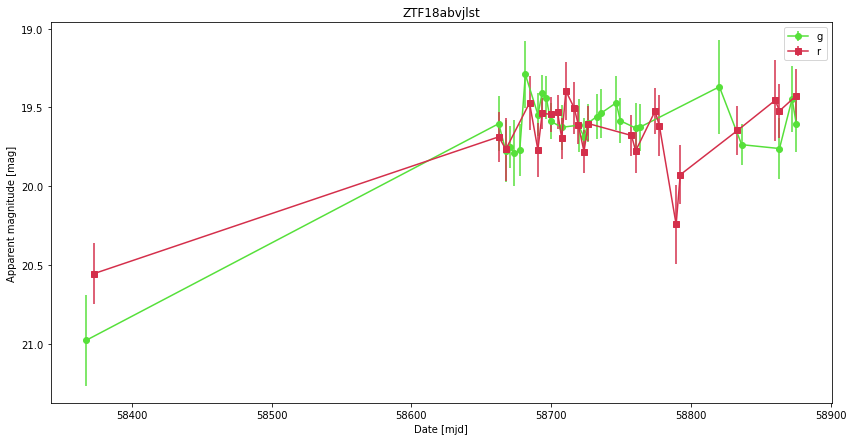

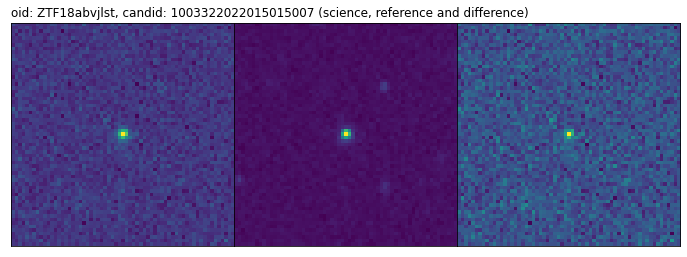

https://dev.alerce.online/object/ZTF20aadchue


/home/ignacio/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in arcsinh


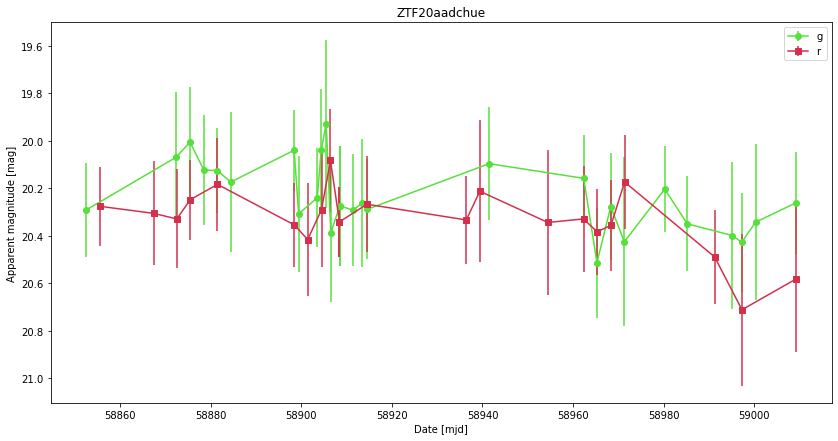

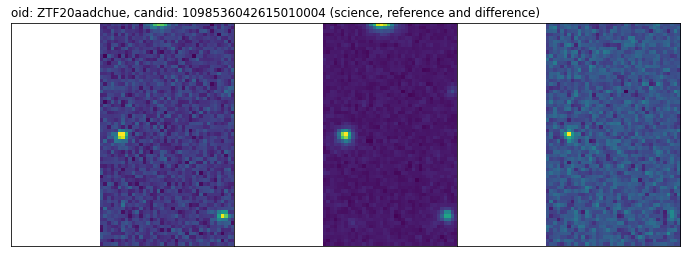

######### SN class #########
https://dev.alerce.online/object/ZTF20aapycrh


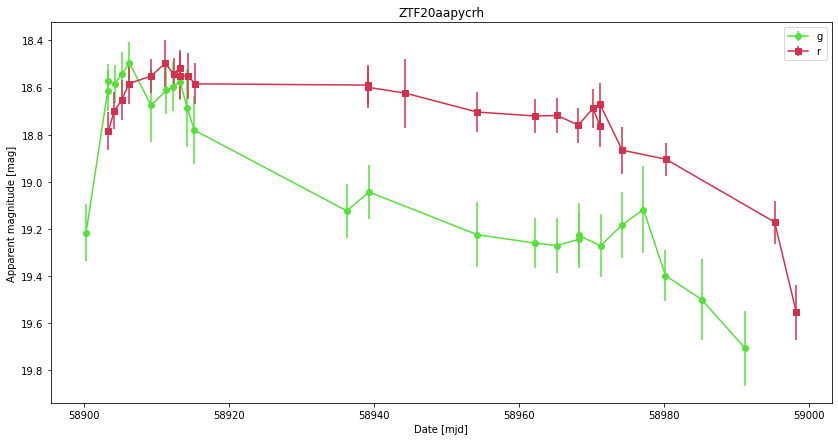

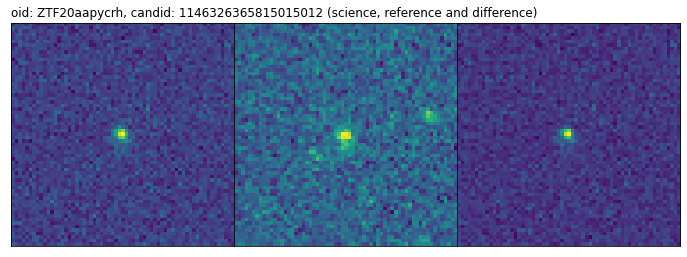

https://dev.alerce.online/object/ZTF20aavzlxm


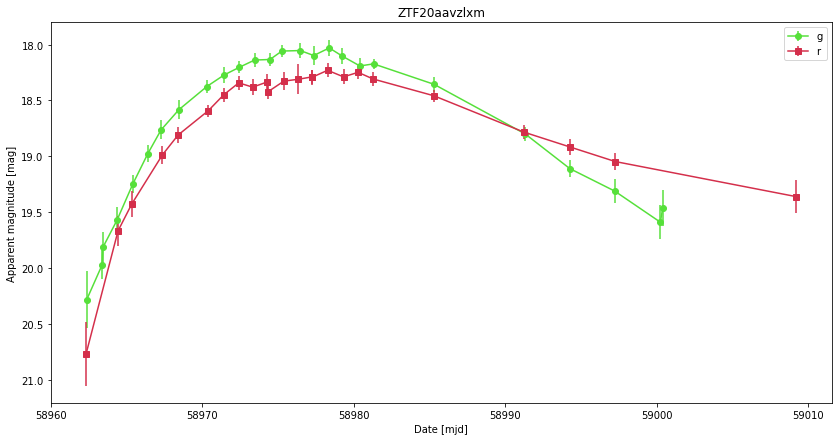

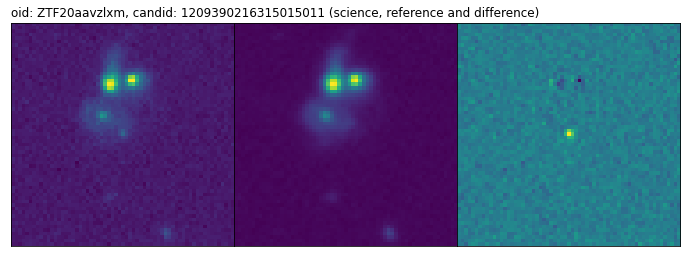

######### VS class #########
https://dev.alerce.online/object/ZTF18aaynxkx


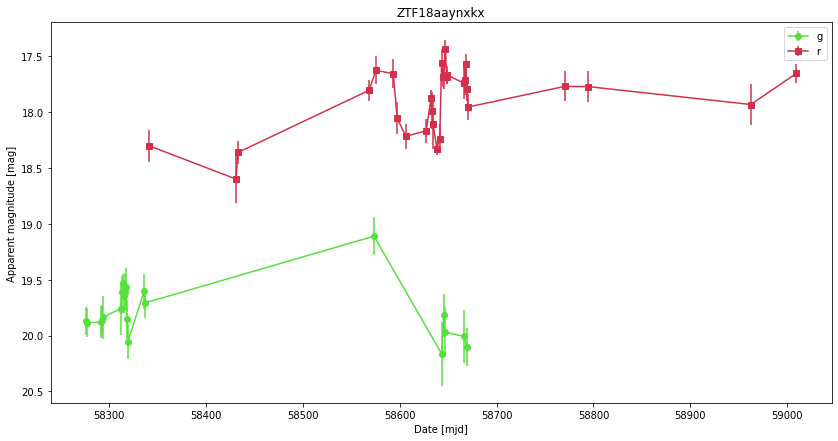

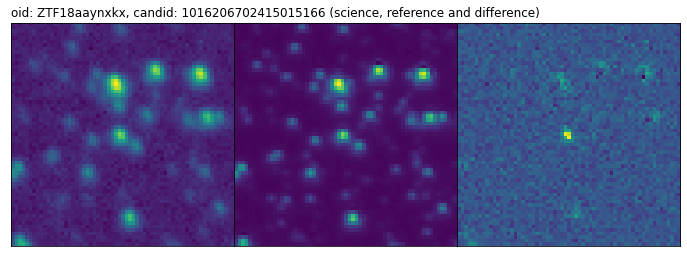

https://dev.alerce.online/object/ZTF18abcsqnl


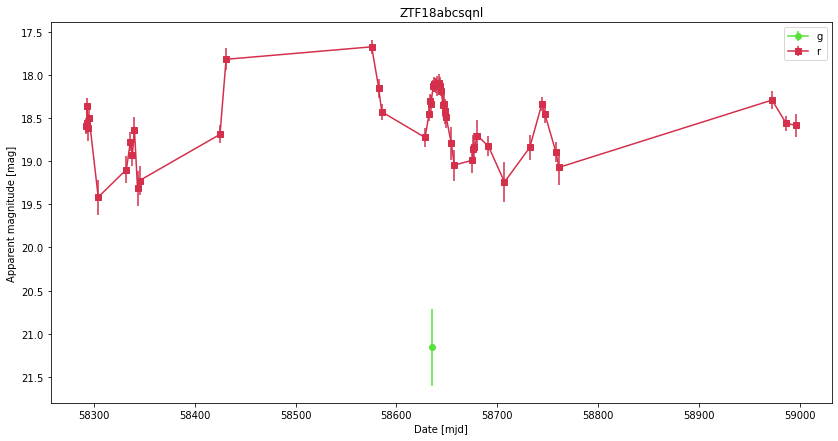

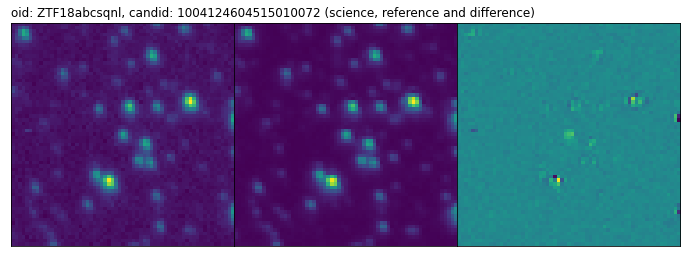

######### Asteroid class #########
https://dev.alerce.online/object/ZTF19aaupwwc


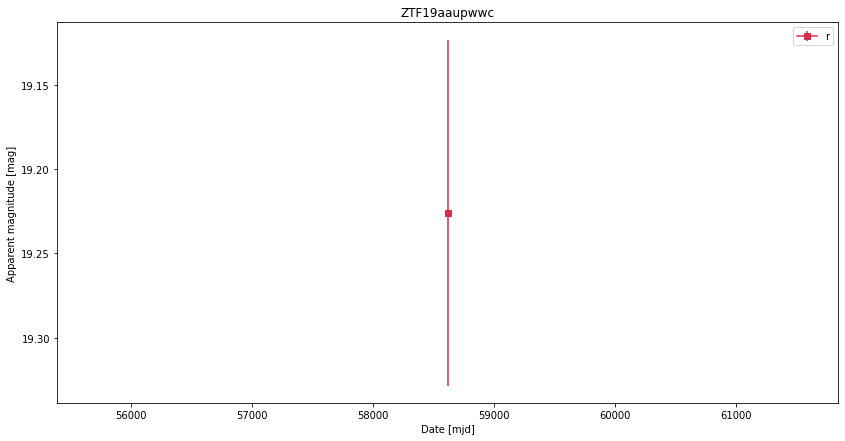

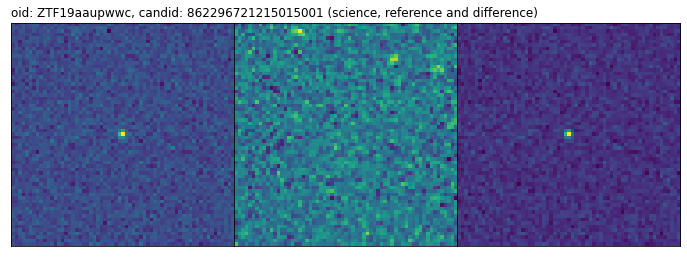

https://dev.alerce.online/object/ZTF18abxvpog


/home/ignacio/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in arcsinh


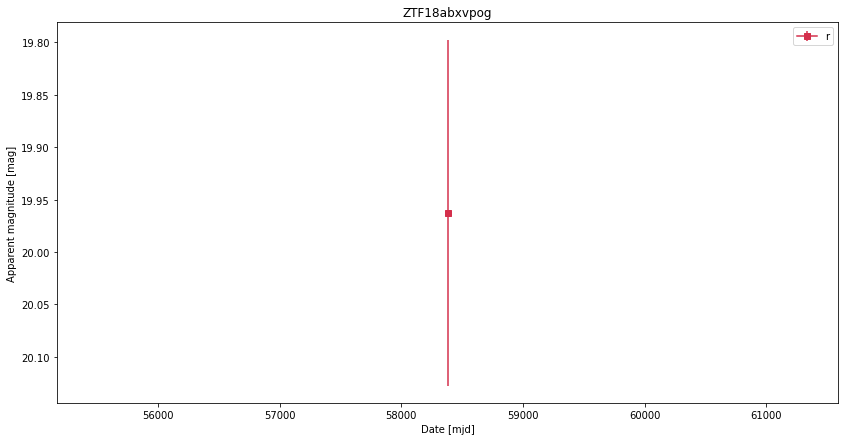

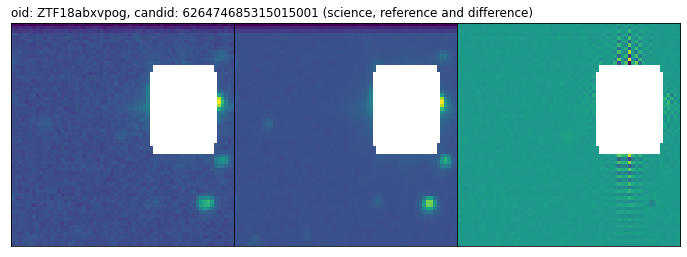

######### Bogus class #########
https://dev.alerce.online/object/ZTF20aalzllb


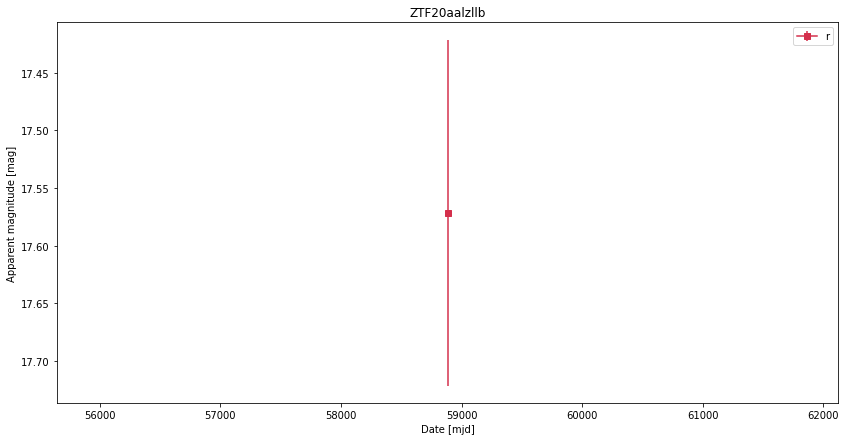

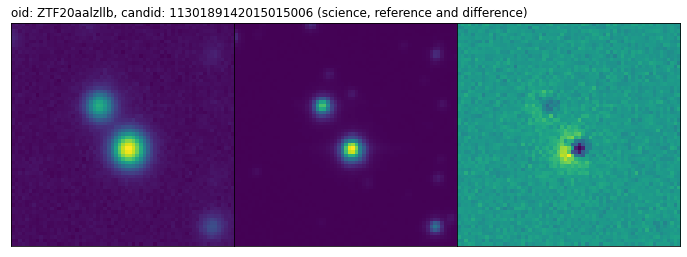

https://dev.alerce.online/object/ZTF20aabrard


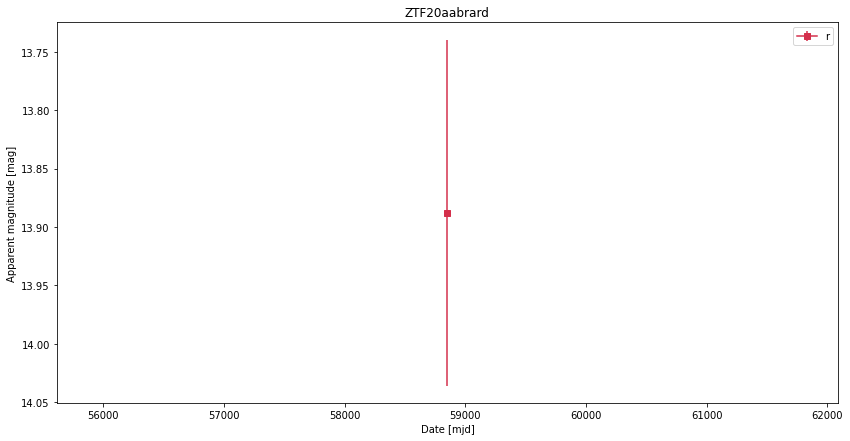

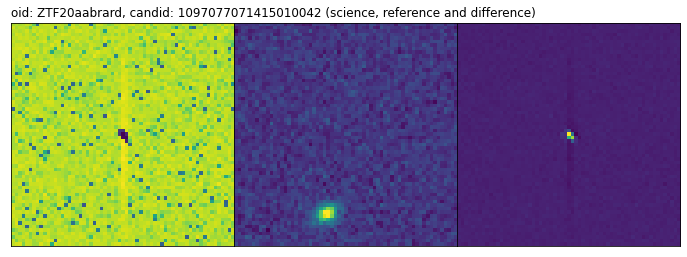

In [41]:
for cl, df in objects.items():
    print("######### "+ cl + " class #########")
    if cl in ["Asteroid", "Bogus"]: # Just to have well classified samples to show
        df.sort_values(by="ndet", inplace=True)
    plot_some_LC(df, n_examples=2)

## Check light curve lengths for predicted objects <a class="anchor" id="stamp-lengths"></a>

The distribution of the number of detections per class can give us insights on how well the classifier is working. For instance, for AGNs, SNe, and VS, we expect to see more than one detection for these classes. The objects belonging to these classes and have one detection could be new objects or the ones visited only once, short transients, or errors in the classification. For asteroids and bogus class, we expect to have objects with one detection only.

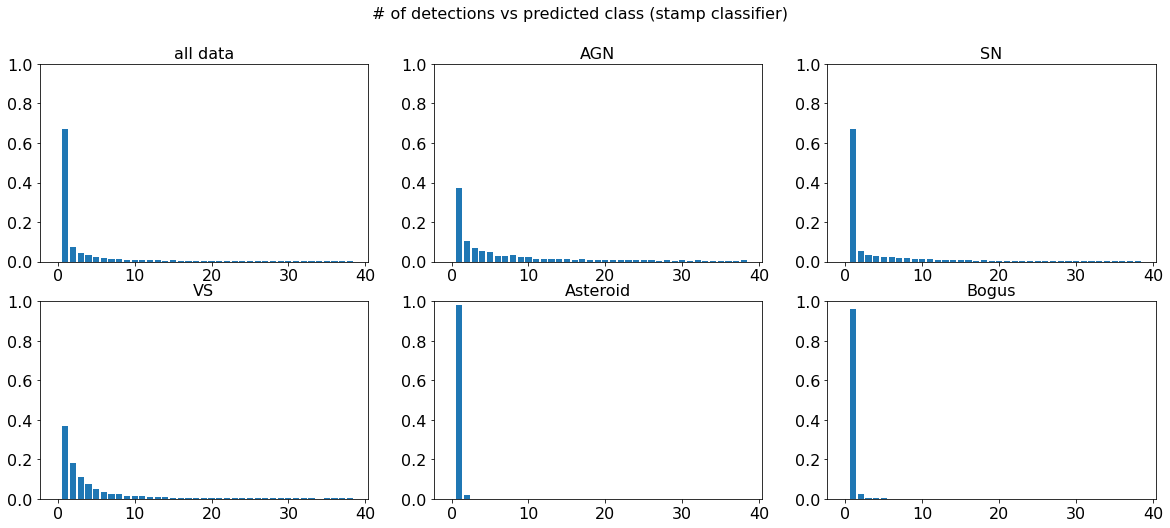

In [17]:
fig, ax = plt.subplots(2, 3, figsize=(20, 8))
fig.set_facecolor('white')
bins = np.arange(0, 40)
ax = ax.flatten()
fontsize = 16

fig.suptitle('# of detections vs predicted class (stamp classifier)', fontsize=fontsize)

# Concatenated dataframe with all the classes
h, _ = np.histogram(pd.concat(list(objects.values()), axis=0).ndet, bins=bins, density=True)
ax[0].bar(bins[:-1], h, label="all_data")
ax[0].set_title("all data", fontsize=fontsize)
ax[0].tick_params(axis='both', which='major', labelsize=fontsize)
ax[0].set_ylim([0, 1])

for i, (cl, df) in enumerate(objects.items()):
    # Histogram per class
    h, bins = np.histogram(df.ndet, bins=bins, density=True)
    ax[i+1].bar(bins[:-1], h, label=cl)
    ax[i+1].set_title(cl, fontsize=fontsize)
    ax[i+1].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[i+1].set_ylim([0, 1])
    
plt.show()

In our small sample we can see that most of the asteroids and bogus have only one detection, while AGNs, SNe and VS have a long tail of objects with more than one detection.

## Spatial distribution of predictions <a class="anchor" id="stamp-spatial"></a>

One issue when training models in astronomy is the possible biases found in the training set. One of the problems we had at the beginning was the abundance of extragalactic objects predicted near the galactic plane. As mentioned in the Introduction, SNe and AGNs are less likely to be found near the galactic plane due to occlusion. We fixed this problem by adding some features to the CNN at the fully connected layers, one of the most important are the ecliptic and galactic coordinates, so let's see how they look like per class.

### Compute galactic and ecliptic coordinates
We computed the coordinates from the meanra and mean dec using the ephem python package. Here (https://rhodesmill.org/pyephem/coordinates.html) there is a more detailed tutorial of how to use this transformation between coordinates. Now, we will take our dataframes and add ecliptic and galactic latitude and longitude as columns.

In [18]:
def ecliptic_coordinates(df):
    # Define the lambda function to be applied to each row of the dataframe
    ecl = df.apply(lambda row: ephem.Ecliptic(ephem.Equatorial('%s' % (row.meanra / 15.),
                                                               '%s' % row.meandec, epoch=ephem.J2000)), axis=1)
    
    # Apply the function to each row, the result is append as a new column
    df["ecl_lat"] = ecl.apply(lambda row: np.rad2deg(row.lat))
    df["ecl_long"] = ecl.apply(lambda row: np.rad2deg(row.long))
    
    # Return the updated dataframe
    return df


def galactic_coordinates(df):
    # Define the lambda function to be applied to each row of the dataframe
    gal = df.apply(lambda row: ephem.Galactic(ephem.Equatorial('%s' % (row.meanra / 15.),
                                                               '%s' % row.meandec, epoch=ephem.J2000)), axis=1)
    # Apply the function to each row, the result is append as a new column
    df["gal_lat"] = gal.apply(lambda row: np.rad2deg(row.lat))
    df["gal_long"] = gal.apply(lambda row: np.rad2deg(row.long))
    
    # Return the updated dataframe
    return df

# For each of our dataframe corresponding to one of the classes of the stamp classifier
# we add the ecliptic and galactic coordinates
for cl, df in objects.items():
    ecl_df = ecliptic_coordinates(df)
    gal_df = galactic_coordinates(ecl_df)
    objects[cl] = gal_df

In [19]:
def plot_spatial_distribution(df, ax, index=0, cmin_val=0.1, vmax_val=5, titles="", fontsize=18, x_label=None, y_label=None):
    dims = ['gal_long', 'gal_lat'] # Let's use our new column to plot the objects
    # This is a 2D histogram of the positions of objects for each of the classes
    _, _, _, im = ax.hist2d(df[dims].values[:, 0], df[dims].values[:, 1],
                            (300, 300), cmap="viridis", vmax=vmax_val, cmin=cmin_val)
    ax.tick_params(axis='both', labelsize=fontsize-2)
    ax.set_xlim([0, 360])
    ax.set_ylim([-80, 80])
    cbar = plt.colorbar(im,ax=ax, pad=0)
    cbar.ax.tick_params(labelsize=fontsize-4)
    
    ecliptic_lat = np.zeros(500)
    ecliptic_longi = np.linspace(0, 360, num=500)
    # This auxiliary function computes the ecliptic plane by converting
    # the ecliptic latitude 0 to galactic coordinates
    # We should find many asteroids near the ecliptic
    ecliptic = SkyCoord(ecliptic_longi, ecliptic_lat, unit='deg', frame='barycentrictrueecliptic')
    galact_long, galact_lat = ecliptic.galactic.l.deg, ecliptic.galactic.b.deg
    
    ax.set_title(titles, fontsize=fontsize)
    ax.plot(galact_long, galact_lat, "ok", markersize=6)
    ax.plot(galact_long, galact_lat, "oy", markersize=4)
    if not x_label is None:
        ax.set_xlabel(x_label, fontsize=fontsize)
    if not y_label is None:
        ax.set_ylabel(y_label, fontsize=fontsize)
    
    return ax

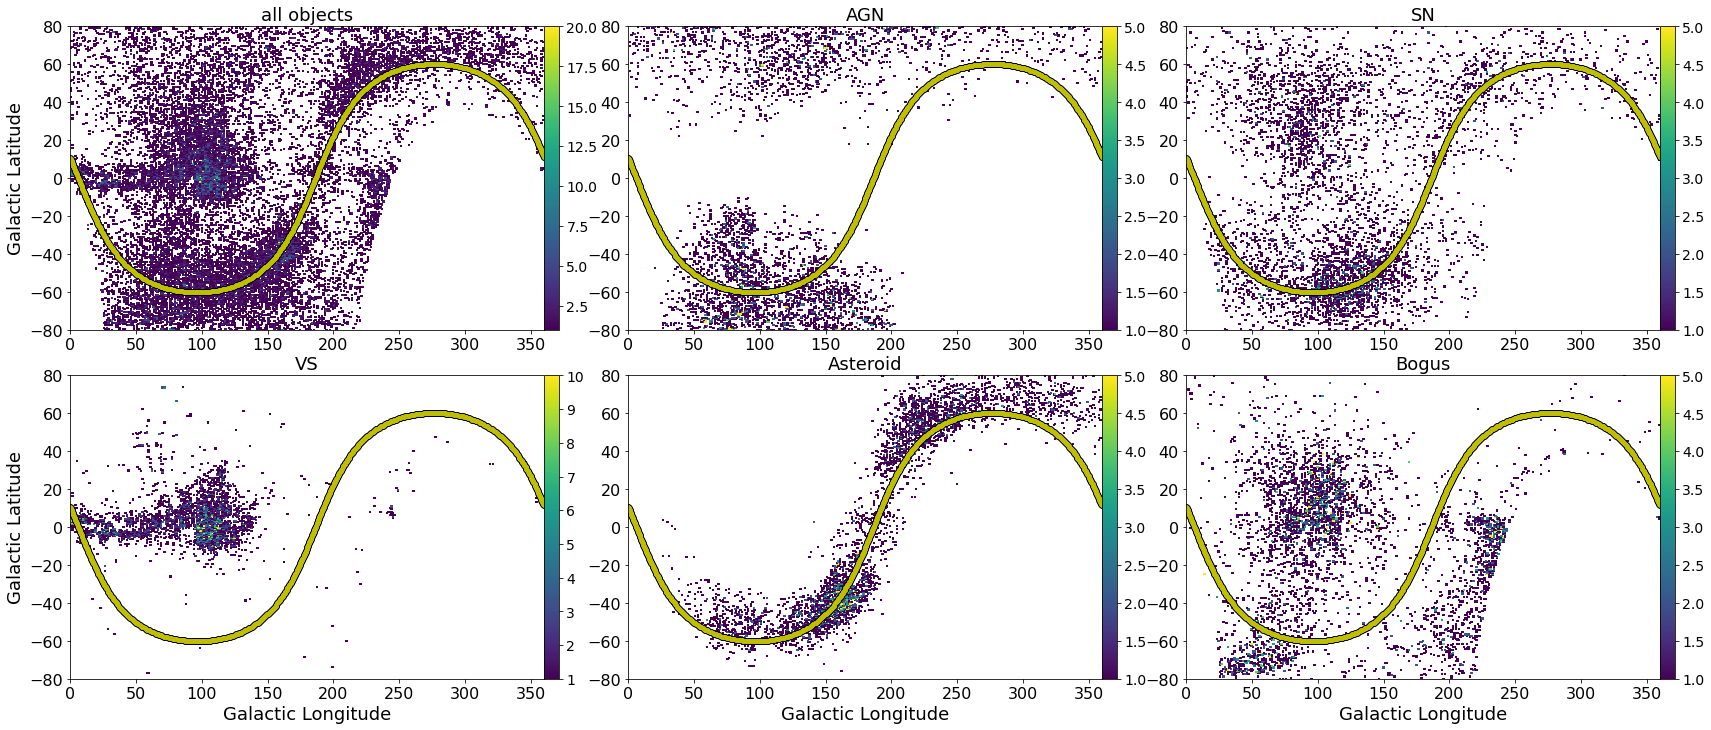

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(3*10, 2*6))
fig.set_facecolor('white')
plt.subplots_adjust(wspace=0.0, hspace=0.15)
ax = ax.flatten() # A trick to iterate over the axis of a subplot array
titles = ["all objects", ] + list(objects.keys())
# This is just to control the saturation of the histograms, the larger
# the number, the larger the amount of objects needed in the same location to increase the color scale
max_count_per_class = dict(zip(titles, [20, 5, 5, 10, 5, 5])) 

for i in range(6):
    x_label = None
    y_label = None
    if i == 0:
        df = pd.concat(list(objects.values()), axis=0)
    else:
        df = list(objects.values())[i-1]
    
    if i in [0, 3]:
        y_label = "Galactic Latitude"
    if i in [3, 4, 5]:
        x_label = "Galactic Longitude"
    ax[i] = plot_spatial_distribution(df, ax[i], titles=titles[i], vmax_val=max_count_per_class[titles[i]], x_label=x_label, y_label=y_label)
plt.show()

Here us the spatial distribution for the unlabeled data, and distribution of predictions per class. The colorbar indicates the density of points. The ecliptic is shown with a yellow line with black edges. The distributions are shown as a 2d histogram of density of alerts. Extragalactic sources (SNe and AGNs) are found outside the Galactic plane. On the contrary, VS are concentrated in the Galactic plane. Asteroids are near the ecliptic.

### Probabilities per class as a function of the position

Even though most of the objects per class lie in a reasonable position according to their nature, there are some errors or contamination between classes. It is interesting to see how certain is the stamp classifier for each class depending on their position, so let’s plot the probability of each object belonging to each class in the same galactic coordinates projection. We only have to modify our previous “plot_spatial_distribution” function to make a scatter plot instead of the 2d histogram. We will fill each scatter dot with a colormap and size that reflects their probability.

In [21]:
def plot_spatial_probabilities(df, ax, index=0, cmin_val=0.1, vmax_val=5, titles="", fontsize=18, x_label=None, y_label=None):
    # We sort the rows of the dataframe first in order to reduces biases when "painting" the plot with the scatter
    df = df.sample(frac=1) 
    dims = ['gal_long', 'gal_lat'] # Let's use our new column to plot the objects
    # We will use the normalized probabilities (between 0 and 1) to scale the size of each dot according 
    # the their probability of belonging to the respective class
    normalized_probabilities_per_class = df["probability"].values - np.amin(df["probability"].values)
    normalized_probabilities_per_class = normalized_probabilities_per_class/np.amax(normalized_probabilities_per_class)
    # Variable size dots for the scatter plot
    variable_sizes = 10 + normalized_probabilities_per_class*100
    color_map = plt.cm.get_cmap('viridis')
    im = ax.scatter(df[dims].values[:, 0], df[dims].values[:, 1], c=df["probability"].values, cmap=color_map,
                   s=variable_sizes, alpha=0.7)
    ax.tick_params(axis='both', labelsize=fontsize-2)
    ax.set_xlim([0, 360])
    ax.set_ylim([-80, 80])
    cbar = plt.colorbar(im,ax=ax, pad=0)
    cbar.ax.tick_params(labelsize=fontsize-4)
    
    ecliptic_lat = np.linspace(0, 0, num=500)
    ecliptic_longi = np.linspace(0, 360, num=500)
    # This auxiliary function computes the ecliptic plane by converting
    # the ecliptic latitude 0 to galactic coordinates
    ecliptic = SkyCoord(ecliptic_longi, ecliptic_lat, unit='deg', frame='barycentrictrueecliptic')
    galact_long, galact_lat = ecliptic.galactic.l.deg, ecliptic.galactic.b.deg
    
    ax.set_title(titles, fontsize=fontsize)
    ax.plot(galact_long, galact_lat, "ok", markersize=6)
    ax.plot(galact_long, galact_lat, "oy", markersize=4)
    
    if not x_label is None:
        ax.set_xlabel(x_label, fontsize=fontsize)
    if not y_label is None:
        ax.set_ylabel(y_label, fontsize=fontsize)
    
    return ax

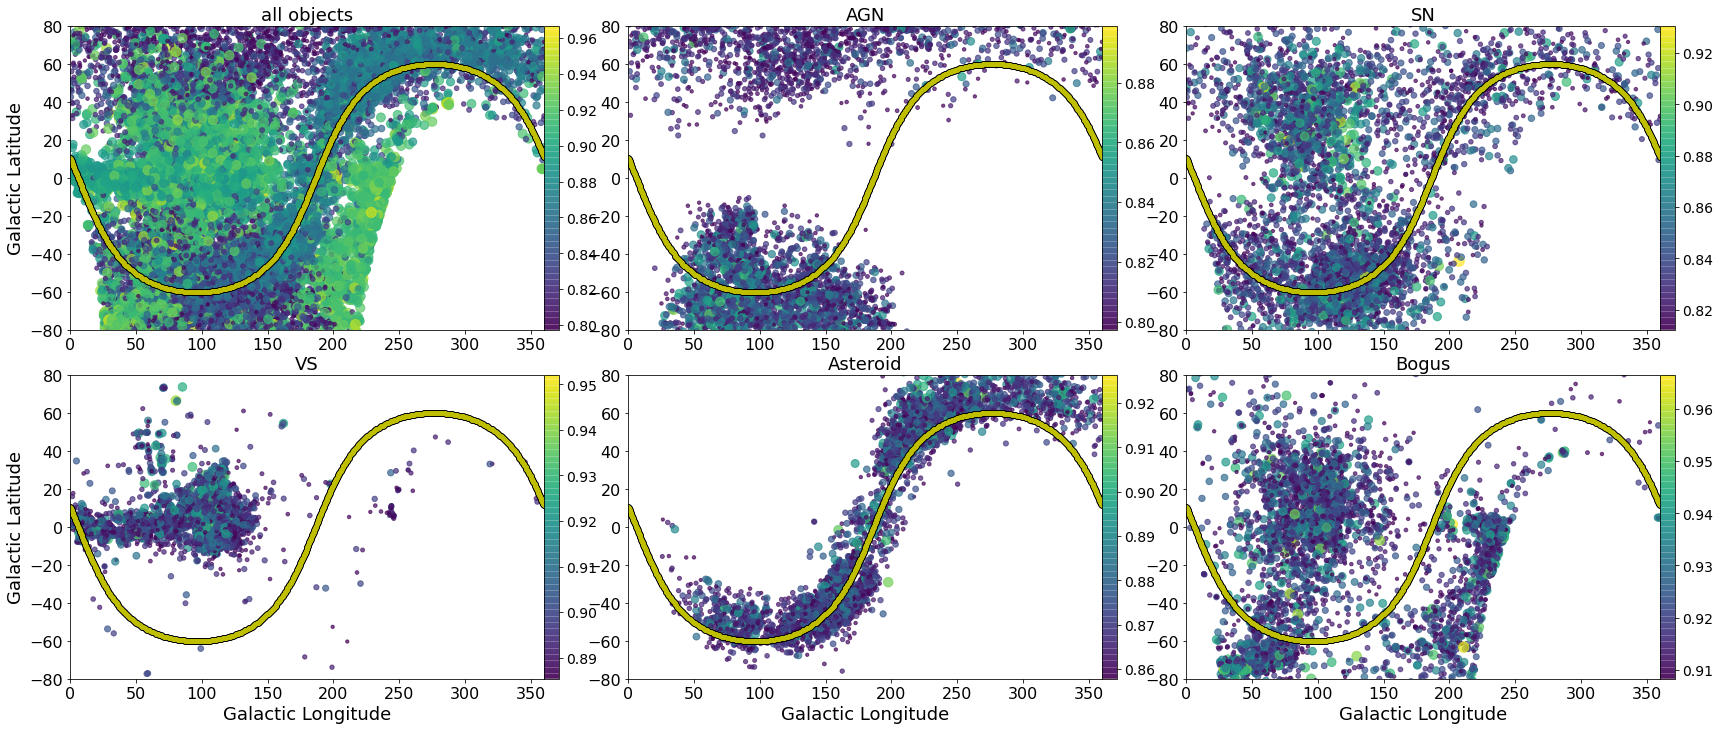

In [22]:
fig, ax = plt.subplots(2, 3, figsize=(3*10, 2*6))
fig.set_facecolor('white')
plt.subplots_adjust(wspace=0.0, hspace=0.15)
ax = ax.flatten() # A trick to iterate over the axis of a subplot array
titles = ["all objects", ] + list(objects.keys())

for i in range(6):
    x_label = None
    y_label = None
    if i == 0:
        df = pd.concat(list(objects.values()), axis=0)
    else:
        df = list(objects.values())[i-1]
    
    if i in [0, 3]:
        y_label = "Galactic Latitude"
    if i in [3, 4, 5]:
        x_label = "Galactic Longitude"
    
    ax[i] = plot_spatial_probabilities(df, ax[i], titles=titles[i], vmax_val=max_count_per_class[titles[i]], x_label=x_label, y_label=y_label)
plt.show()

For the SN class, the stamp classifier seems to be more confident about the prediction further from the ecliptic, there is a large blob of green-yellow dots at around (40, 120), while darker blobs near the ecliptic, meaning less confidence in the prediction. We can also see a greener blob near the center of the galaxy in the case of variable stars. In addition, it is also important to know the relative confidence between classes, some classes are harder to classify than others as you can see in the “all objects” scatter. Now, we will plot the distribution of probabilities per class.

# Light curve classifier <a class="anchor" id="lc"></a>

## Description <a class="anchor" id="lc-description"></a>
This section shows the light curve classifier from ALeRCE, described in detail in "Alert Classification for the ALeRCE Broker System: The Light Curve Classifier" by Sánchez-Sáez et. al (2020, under review).

The training set for the light curve classifier was built by cross matching ZTF with many astronomical catalogs with objects from known categories. The current training set of ALeRCE contains more than 1700 supernovae from many subclasses, almost 35k stochastic sources (QSO, AGN, Blazar, YSO, CV/Nova) and 87k light curves from periodic stars.

### Model description
When a light curve has more than 5 alerts in any of its bands it's classified by our light curve classifier. The model uses Machine Learning, combining feature extraction of the light curves and a model build of 4 Random Forest classifiers. Each object is classified in 15 astrophysical categories according to the following taxonomy.

<img src="figures/ml/taxonomy.png" width=70%/>

Our classifier takes the light curve of an object, information about non-detections (previous ZTF observations where no alerts were generated), the metadata available from ZTF (e.g. coordinates) and cross match data from WISE if available. Using that data, more than 150 features are computed.

Some of the computed features are:
* Irregular autoregressive model from Eyheramendy et al. (2018).
* Mexican hat power spectrum from Arévalo et al. (2012).
* Parameters from a damped random walk model from Graham et al. (2017).
* Structure function from Schmidt et al. (2010).
* Multiband periodogram from Mondrik et al. (2015).

Once the features are computed they are classified by 4 Random Forest models, grouped in a hierarchy with two levels. The random forest on the top level classifies each object into 3 main categories: stochastic, transient and periodic sources. After that, each object is processed by 3 random forest classifiers in the bottom level, each one specialized in one category of objects.

For example, the Transient Random Forest provides as output a vector with 4 probabilities, which corresponds to the probability of being a SN type Ia, SN type Ibc, SN type II or superluminous supernova.

Finally, the outputs of the 4 classsifiers are combined using the total probabilities rule. That means that the probability of an object being a cepheid according to our classifier is the product of the object being a periodic star (computed by the random forest of the top level) and the probability of the object being a cepheid (computed by the periodic random forest).

<img src="figures/ml/hierarchical_rf.png" width=50%/>

## Results

The following confusion matrix is a summary of the performance of the model over the test set. This figure shows that the classifier is able to separate among the different classes. Of course some classes are difficult to distinguish, but the mistakes are "reasonable" in the sense that most of them choose a similar class. For example, most misclassified supernovae type Ia are labeled as another kind of supernova.

The black boxes in the figure indicate the confusion inside of one of the three main categories: transient sources, periodic stars and stochastic objects.

<img src="figures/ml/sanchez_paper_confusion_matrix.png" width=60%/>

## Querying the DB to retrieve predictions <a class="anchor" id="db-query"></a>

In [23]:
credentials_file = "../alercereaduser_v3.json"
if os.path.exists(credentials_file):
    with open(credentials_file) as jsonfile:
        params = json.load(jsonfile)["params"]
else:
    url = "https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v3.json"
    params = requests.get(url).json()['params']
    
conn = psycopg2.connect(
    dbname=params['dbname'], 
    user=params['user'], 
    host=params['host'], 
    password=params['password'])

In [24]:
# Heavy query (~ 2 min)
query = "select * from probability where classifier_name = 'lc_classifier' and ranking = 1;"
bhrf_predictions = pd.read_sql_query(query, conn)
bhrf_predictions

,oid,classifier_name,classifier_version,class_name,probability,ranking
0,ZTF18absjiqh,lc_classifier,bulk_0.0.1,YSO,0.366804,1
1,ZTF18abuvydm,lc_classifier,bulk_0.0.1,DSCT,0.548496,1
2,ZTF18aavznxg,lc_classifier,bulk_0.0.1,E,0.429640,1
3,ZTF18aabgcoi,lc_classifier,bulk_0.0.1,E,0.643416,1
4,ZTF19aaynwbd,lc_classifier,bulk_0.0.1,Periodic-Other,0.333560,1
...,...,...,...,...,...,...
869877,ZTF18achrhsg,lc_classifier,bulk_0.0.1,Periodic-Other,0.616028,1
869878,ZTF19aaqsrto,lc_classifier,bulk_0.0.1,Periodic-Other,0.463896,1
869879,ZTF18abvqece,lc_classifier,bulk_0.0.1,YSO,0.344448,1
869880,ZTF18abiyzdu,lc_classifier,bulk_0.0.1,Periodic-Other,0.424764,1


## Histogram of predicted classes <a class="anchor" id="lc-histogram"></a>

Text(0.5, 1.0, 'Predicted class frequency')

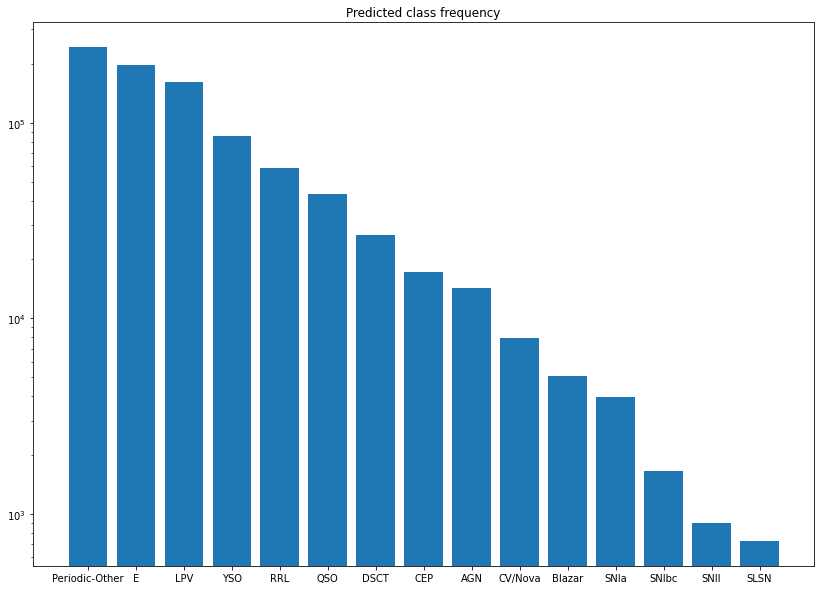

In [25]:
pred_classes_count = bhrf_predictions.groupby('class_name').count()['oid']
pred_classes_count = pred_classes_count.sort_values(ascending=False)
fig = plt.figure(figsize=(14, 10))
fig.patch.set_facecolor('white')
plt.bar(pred_classes_count.index.values, pred_classes_count.values)
plt.gca().set_yscale('log')
plt.title('Predicted class frequency')

## Spatial distribution of the predictions <a class="anchor" id="lc-spatial"></a>
### Galactic sources (LPV, CEP, YSO)

In [26]:
galactic_sources = bhrf_predictions[bhrf_predictions['class_name'].isin(
    ['LPV', 'CEP', 'YSO'])]
galactic_sources

,oid,classifier_name,classifier_version,class_name,probability,ranking
0,ZTF18absjiqh,lc_classifier,bulk_0.0.1,YSO,0.366804,1
10,ZTF18abikbpk,lc_classifier,bulk_0.0.1,YSO,0.347700,1
13,ZTF18abmwppq,lc_classifier,bulk_0.0.1,YSO,0.221160,1
16,ZTF18ablrqej,lc_classifier,bulk_0.0.1,LPV,0.417040,1
21,ZTF18aaxulyi,lc_classifier,bulk_0.0.1,LPV,0.910344,1
...,...,...,...,...,...,...
869861,ZTF19aavndux,lc_classifier,bulk_0.0.1,YSO,0.539136,1
869867,ZTF19aaqrowo,lc_classifier,bulk_0.0.1,LPV,0.382072,1
869872,ZTF18aavloef,lc_classifier,bulk_0.0.1,YSO,0.477000,1
869876,ZTF18aczozrk,lc_classifier,bulk_0.0.1,YSO,0.476112,1


In [27]:
# Heavy query (~ 2 min)
query = "select oid, name, value from feature where name = 'gal_l' or name = 'gal_b';"
features = pd.read_sql_query(query, conn)
features

,oid,name,value
0,ZTF18aawxhet,gal_l,231.181936
1,ZTF18aauehcp,gal_b,6.194058
2,ZTF19acvsmip,gal_b,-4.491037
3,ZTF18abzncso,gal_l,35.345426
4,ZTF18abboaqn,gal_l,111.205751
...,...,...,...
1736737,ZTF18abqcsvc,gal_b,-6.120418
1736738,ZTF18abchqyi,gal_b,4.526834
1736739,ZTF19aaapmat,gal_l,354.614619
1736740,ZTF18absbzwa,gal_b,3.137213


In [28]:
gal_l = features[features.name == 'gal_l'].copy()
gal_l.rename(columns={'value': 'gal_l'}, inplace=True)
gal_l.drop(columns=['name'], inplace=True)
gal_l.set_index('oid', inplace=True)

gal_b = features[features.name == 'gal_b'].copy()
gal_b.rename(columns={'value': 'gal_b'}, inplace=True)
gal_b.drop(columns=['name'], inplace=True)
gal_b.set_index('oid', inplace=True)

coordinates = pd.concat([gal_l, gal_b], sort=True, axis=1)
coordinates

,gal_l,gal_b
ZTF17aaaaaal,150.836439,-2.113667
ZTF17aaaaaam,151.324460,-2.308569
ZTF17aaaaaan,156.195104,-3.562309
ZTF17aaaaaao,156.135688,-3.847876
ZTF17aaaaaas,155.698151,0.933249
...,...,...
ZTF20abcxusg,56.748330,-14.651520
ZTF20abdakny,67.605013,30.384131
ZTF20abdakyh,94.409475,20.417126
ZTF20abdbirw,55.903948,31.209202


In [29]:
n_per_class = 1000        # sample size
replace = False  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, n_per_class, replace),:]
galactic_sources_subset = galactic_sources.groupby('class_name', as_index=False).apply(fn)
galactic_sources_subset = galactic_sources_subset.droplevel(level=0)
galactic_sources_subset


,oid,classifier_name,classifier_version,class_name,probability,ranking
9606,ZTF18aaxjkdt,lc_classifier,bulk_0.0.1,CEP,0.450264,1
707082,ZTF18abnopqa,lc_classifier,bulk_0.0.1,CEP,0.243712,1
199488,ZTF18aamdujv,lc_classifier,bulk_0.0.1,CEP,0.277752,1
819214,ZTF19aanjvnu,lc_classifier,bulk_0.0.1,CEP,0.197508,1
818095,ZTF18abgjqid,lc_classifier,bulk_0.0.1,CEP,0.243880,1
...,...,...,...,...,...,...
768894,ZTF18acmytlw,lc_classifier,bulk_0.0.1,YSO,0.259128,1
459702,ZTF18abjrggo,lc_classifier,bulk_0.0.1,YSO,0.327236,1
667820,ZTF17aabpjnz,lc_classifier,bulk_0.0.1,YSO,0.215016,1
19582,ZTF19aafomkn,lc_classifier,bulk_0.0.1,YSO,0.226800,1


Text(0.5, 1.0, 'Spatial distribution of predictions: LPV, CEP, YSO')

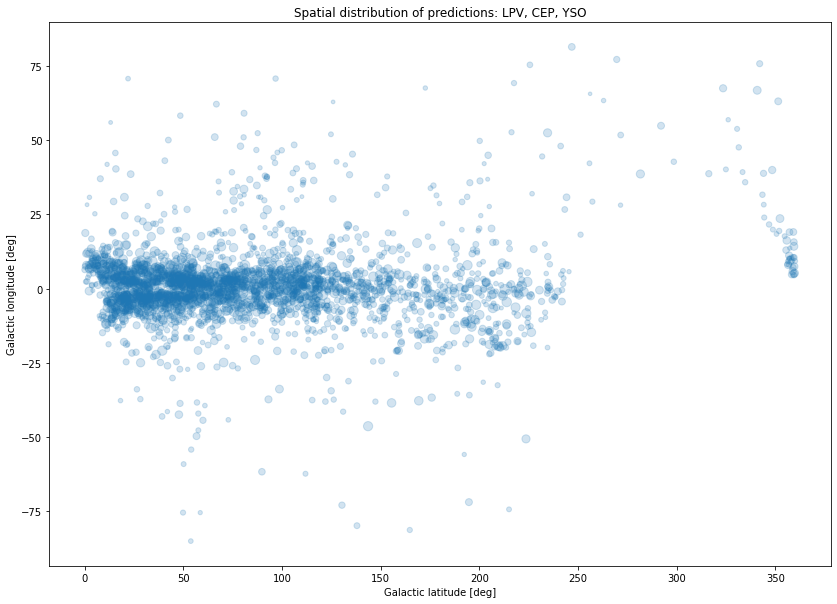

In [30]:
coordinates_subset = coordinates.loc[galactic_sources_subset.oid]
fig = plt.figure(figsize=(14, 10))
fig.patch.set_facecolor('white')
plt.scatter(
    coordinates_subset.values[:, 0],
    coordinates_subset.values[:, 1],
    alpha=0.2,
    s=galactic_sources_subset.probability*100
)
plt.xlabel('Galactic latitude [deg]')
plt.ylabel('Galactic longitude [deg]')
plt.title('Spatial distribution of predictions: LPV, CEP, YSO')

### Extragalactic sources (QSO, AGN, Blazar, SNe)

In [31]:
extragalactic_sources = bhrf_predictions[bhrf_predictions['class_name'].isin(
    ['QSO', 'Blazar', 'SNIa', 'SNII', 'AGN', 'SNIbc', 'SLSN'])]
extragalactic_sources

,oid,classifier_name,classifier_version,class_name,probability,ranking
25,ZTF19aacwnxy,lc_classifier,bulk_0.0.1,QSO,0.482160,1
42,ZTF20aaitsnj,lc_classifier,bulk_0.0.1,QSO,0.948000,1
57,ZTF18acwwsin,lc_classifier,bulk_0.0.1,QSO,0.374400,1
65,ZTF19aanfyey,lc_classifier,bulk_0.0.1,SNIa,0.440000,1
85,ZTF19aanntcu,lc_classifier,bulk_0.0.1,QSO,0.882000,1
...,...,...,...,...,...,...
869818,ZTF18abtmwun,lc_classifier,bulk_0.0.1,AGN,0.819000,1
869823,ZTF19acxqaaz,lc_classifier,bulk_0.0.1,QSO,0.355320,1
869824,ZTF18acdyfue,lc_classifier,bulk_0.0.1,Blazar,0.857960,1
869842,ZTF19aazdiwq,lc_classifier,bulk_0.0.1,SNIbc,0.337560,1


In [32]:
n_per_class = 100        # sample size
replace = False  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, n_per_class, replace),:]
extragalactic_sources_subset = extragalactic_sources.groupby('class_name', as_index=False).apply(fn)
extragalactic_sources_subset = extragalactic_sources_subset.droplevel(level=0)
extragalactic_sources_subset

,oid,classifier_name,classifier_version,class_name,probability,ranking
15415,ZTF18aazgqkb,lc_classifier,bulk_0.0.1,AGN,0.602208,1
255140,ZTF20aatukyv,lc_classifier,bulk_0.0.1,AGN,0.621888,1
116599,ZTF18acclaad,lc_classifier,bulk_0.0.1,AGN,0.659288,1
281659,ZTF19aaaemmb,lc_classifier,bulk_0.0.1,AGN,0.559468,1
328787,ZTF18abkigvh,lc_classifier,bulk_0.0.1,AGN,0.582072,1
...,...,...,...,...,...,...
867579,ZTF19aamvape,lc_classifier,bulk_0.0.1,SNIbc,0.417164,1
674345,ZTF18absiwvr,lc_classifier,bulk_0.0.1,SNIbc,0.200320,1
567162,ZTF19aapvtfl,lc_classifier,bulk_0.0.1,SNIbc,0.201828,1
430412,ZTF19abctvcx,lc_classifier,bulk_0.0.1,SNIbc,0.247416,1


Text(0.5, 1.0, 'Spatial distribution of extragalactic pred. sources')

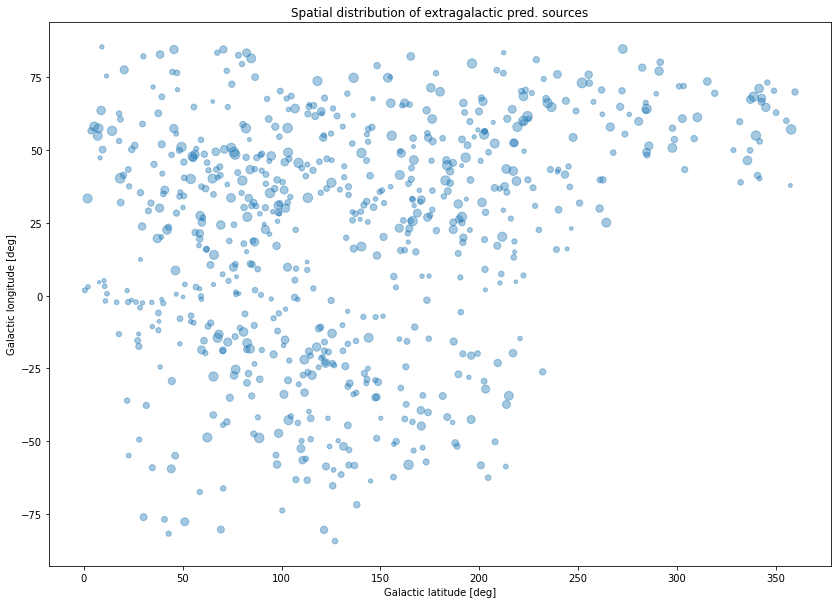

In [33]:
coordinates_subset = coordinates.loc[extragalactic_sources_subset.oid]
fig = plt.figure(figsize=(14, 10))
fig.patch.set_facecolor('white')
plt.scatter(
    coordinates_subset.values[:, 0],
    coordinates_subset.values[:, 1],
    alpha=0.4,
    s=extragalactic_sources_subset.probability*100
)
plt.xlabel('Galactic latitude [deg]')
plt.ylabel('Galactic longitude [deg]')
plt.title('Spatial distribution of extragalactic pred. sources')

## Visualizing a sample of predicted objects <a class="anchor" id="lc-visualization"></a>

In [59]:
n_per_class = 1        # sample size
minimum_probability = 0.3
replace = False  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, n_per_class, replace),:]
filtered_bhrf_predictions = bhrf_predictions[bhrf_predictions.probability >= minimum_probability]
sample_per_class = filtered_bhrf_predictions.groupby('class_name', as_index=False).apply(fn)
sample_per_class = sample_per_class.droplevel(level=0)
sample_per_class

,oid,classifier_name,classifier_version,class_name,probability,ranking
761059,ZTF18aaqdrvn,lc_classifier,bulk_0.0.1,AGN,0.373068,1
273723,ZTF18acszohd,lc_classifier,bulk_0.0.1,Blazar,0.369840,1
109607,ZTF18abdeeoo,lc_classifier,bulk_0.0.1,CEP,0.471040,1
75192,ZTF18aawvlsm,lc_classifier,bulk_0.0.1,CV/Nova,0.348432,1
596640,ZTF18abjxvzf,lc_classifier,bulk_0.0.1,DSCT,0.333984,1
196418,ZTF18acgoagl,lc_classifier,bulk_0.0.1,E,0.537004,1
808487,ZTF18abgioyg,lc_classifier,bulk_0.0.1,LPV,0.695188,1
375781,ZTF18aberqpl,lc_classifier,bulk_0.0.1,Periodic-Other,0.513912,1
143532,ZTF19aamhjwx,lc_classifier,bulk_0.0.1,QSO,0.914328,1
547980,ZTF18adalcaq,lc_classifier,bulk_0.0.1,RRL,0.600000,1


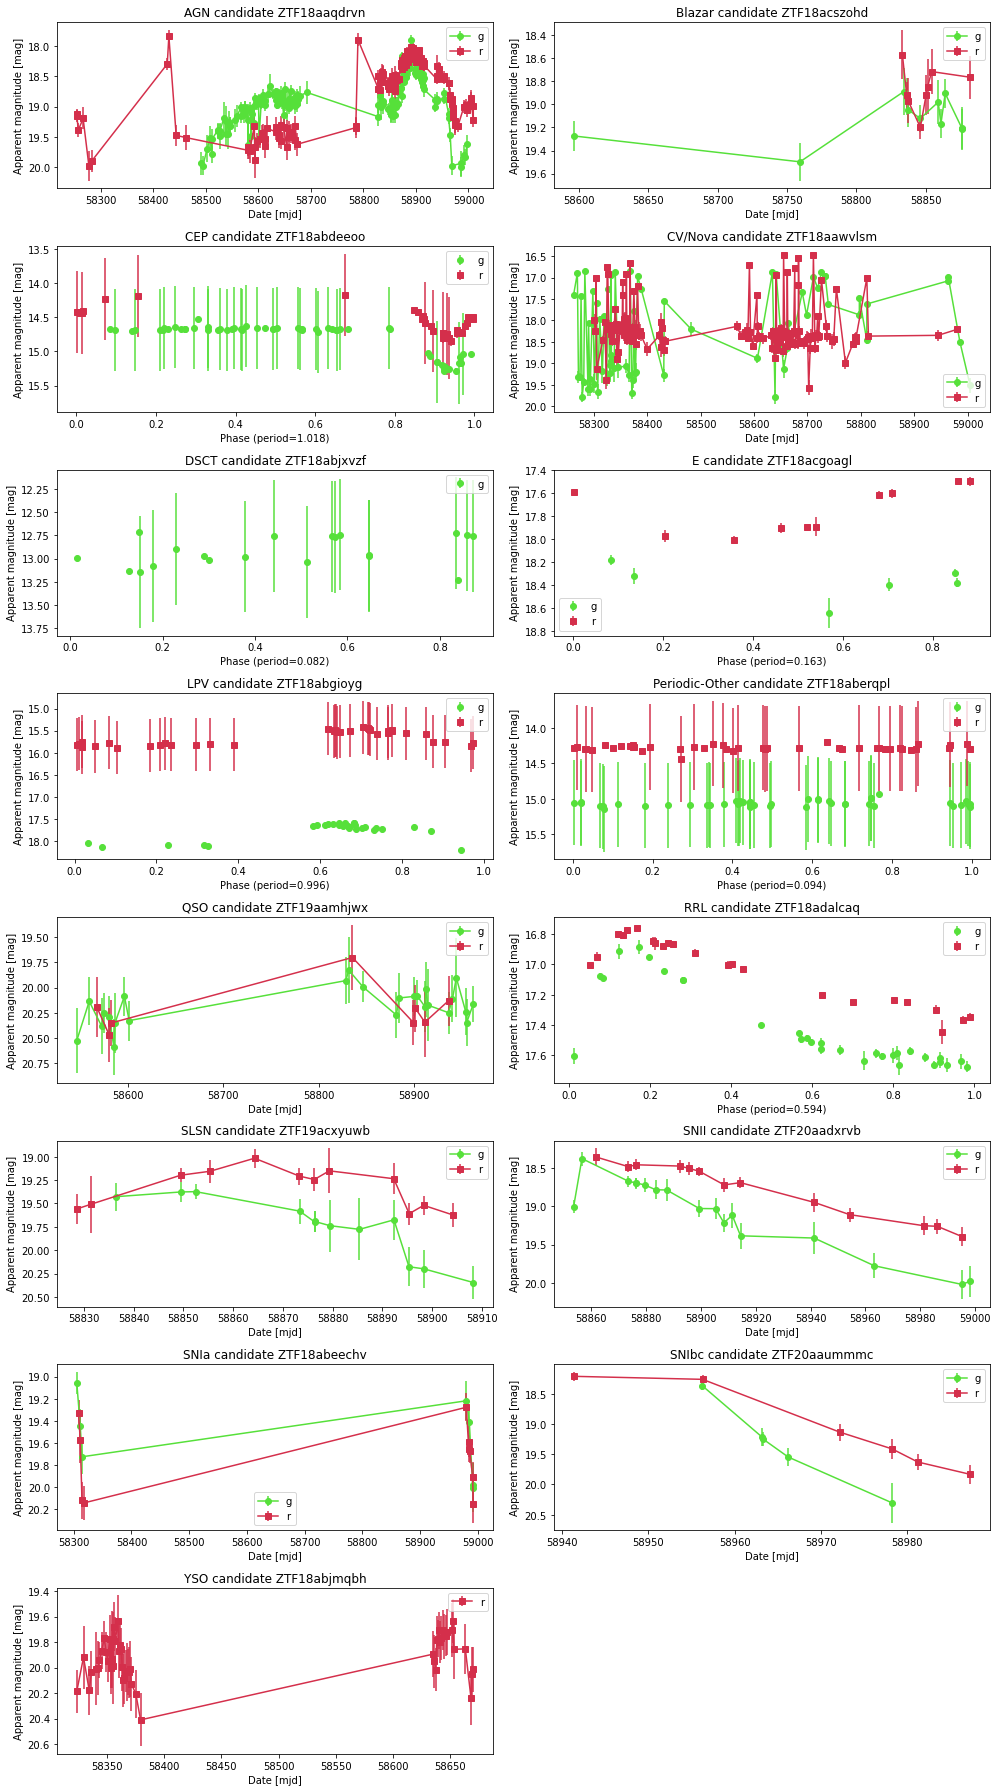

In [60]:
fig = plt.figure(figsize=(14, 25))
fig.patch.set_facecolor('white')
for index in range(len(sample_per_class)):
    astro_class = sample_per_class['class_name'].values[index]
    oid = sample_per_class['oid'].values[index]
    light_curve = alerce_client.query_detections(oid, format='pandas')
    plt.subplot(8, 2, index+1)
    period = None
    if astro_class in ['CEP', 'E', 'DSCT', 'LPV', 'Periodic-Other', 'RRL']:
        query = f"select oid, name, value from feature where name = 'Multiband_period' and oid = '{oid}';"
        period_df = pd.read_sql_query(query, conn)
        if len(period_df) > 0:
            period = float(period_df.value.values[0])
    plotLC(light_curve, SN_nondet=None, title=f'{astro_class} candidate {oid}', period=period, omit_figure=True)
plt.tight_layout()